https://medium.com/@mikkokotila/a-comprehensive-list-of-hyperparameter-optimization-tuning-solutions-88e067f19d9

https://towardsdatascience.com/hyperparameter-optimization-in-python-part-0-introduction-c4b66791614b

# Sklearn and keras built in hyperparameter optimization

https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py

https://github.com/scikit-optimize/scikit-optimize

# Tuning a scikit-learn estimator with `skopt`

Gilles Louppe, July 2016 <br />
Katie Malone, August 2016

If you are looking for a `GridSearchCV` replacement checkout [the `BayesSearchCV` example](sklearn-gridsearchcv-replacement.ipynb) instead.

In [0]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 3.1MB/s 


In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Problem statement

Tuning the hyper-parameters of a machine learning model is often carried out using an exhaustive exploration of (a subset of) the space all hyper-parameter configurations (e.g., using `sklearn.model_selection.GridSearchCV`), which often results in a very time consuming operation. 

In this notebook, we illustrate how to couple `gp_minimize` with sklearn's estimators to tune hyper-parameters using sequential model-based optimisation, hopefully resulting in equivalent or better solutions, but within less evaluations. 

Note: scikit-optimize provides a dedicated interface for estimator tuning via `BayesSearchCV` class which has a similar interface to those of `GridSearchCV`. This class uses functions of skopt to perform hyperparameter search efficiently. For example usage of this class, see [the `BayesSearchCV` example](sklearn-gridsearchcv-replacement.ipynb) example notebook.

## Objective 

To tune the hyper-parameters of our model we need to define a model, decide which parameters to optimize, and define the objective function we want to minimize.

In [0]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

boston = load_boston()
X, y = boston.data, boston.target
n_features = X.shape[1]

# gradient boosted trees tend to do well on problems like this
reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

Next, we need to define the bounds of the dimensions of the search space we want to explore and pick the objective. In this case the cross-validation mean absolute error of a gradient boosting regressor over the Boston dataset, as a function of its hyper-parameters.

In [0]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args


# The list of hyper-parameters we want to optimize. For each one we define the bounds,
# the corresponding scikit-learn parameter name, as well as how to sample values
# from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set scikit-learn
# estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Optimize all the things!

With these two pieces, we are now ready for sequential model-based optimisation. Here we use gaussian process-based optimisation.

In [0]:

from skopt import gp_minimize, forest_minimize, dummy_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

n_calls=50


# Random search
dummy_res = dummy_minimize(objective, space, n_calls=n_calls, random_state=0) 
print("Random search Best score=%.4f" % dummy_res.fun)

# Gaussian processes
gp_res = gp_minimize(objective, space, n_calls=n_calls, random_state=0) 
print("Gaussian Process Best score=%.4f" % gp_res.fun)

# Random forest
rf_res = forest_minimize(objective, space, n_calls=n_calls, random_state=0, base_estimator="RF") 
print("Random forest Best score=%.4f" % rf_res.fun)

# Extra trees 
et_res = forest_minimize(objective, space, n_calls=n_calls, random_state=0, base_estimator="ET") 
print("Extra trees Best score=%.4f" % et_res.fun)



Random search Best score=3.0747
Gaussian Process Best score=2.9453
Random forest Best score=2.7968
Extra trees Best score=2.9473


In [0]:
print("""Random search Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (dummy_res.x[0], dummy_res.x[1], 
                            dummy_res.x[2], dummy_res.x[3], 
                            dummy_res.x[4]))

print("""Gaussian Process Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (gp_res.x[0], gp_res.x[1], 
                            gp_res.x[2], gp_res.x[3], 
                            gp_res.x[4]))

print("""Random forest Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (rf_res.x[0], rf_res.x[1], 
                            rf_res.x[2], rf_res.x[3], 
                            rf_res.x[4]))

print("""Extra trees Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (et_res.x[0], et_res.x[1], 
                            et_res.x[2], et_res.x[3], 
                            et_res.x[4]))



Random search Best parameters:
- max_depth=5
- learning_rate=0.443079
- max_features=12
- min_samples_split=13
- min_samples_leaf=3
Gaussian Process Best parameters:
- max_depth=5
- learning_rate=0.106481
- max_features=11
- min_samples_split=100
- min_samples_leaf=1
Random forest Best parameters:
- max_depth=5
- learning_rate=0.124496
- max_features=6
- min_samples_split=3
- min_samples_leaf=3
Extra trees Best parameters:
- max_depth=3
- learning_rate=0.204367
- max_features=13
- min_samples_split=51
- min_samples_leaf=2


## Convergence plot

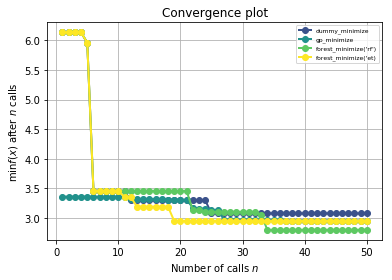

In [0]:
from skopt.plots import plot_convergence


plot = plot_convergence(("dummy_minimize", dummy_res),
                        ("gp_minimize", gp_res),
                        ("forest_minimize('rf')", rf_res),
                        ("forest_minimize('et)", et_res))
plot.legend(loc="best", prop={'size': 6}, numpoints=1);

# Keras hyperparameter optimization

https://blog.floydhub.com/guide-to-hyperparameters-search-for-deep-learning-models/

https://github.com/autonomio/talos

<img src='https://raw.githubusercontent.com/autonomio/hyperio/master/logo.png' width=250px>

In [0]:
#!pip install talos
!pip install git+https://github.com/autonomio/talos.git@daily-dev
!pip install git+https://github.com/mikkokotila/astetik
!rm datasets.py
!wget "https://raw.githubusercontent.com/autonomio/talos/production/talos/examples/datasets.py"

In [0]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import talos as ta
import pandas as pd
import os
import sys
sys.path.append(os.getcwd())
import datasets

%matplotlib inline

## Table of Contents

##### 1. <a href=#one>Data Preparation</a>
##### 2. <a href=#two>Model Preparation</a>
##### 3. <a href=#three>Setting the Parameter Space Boundaries</a>
##### 4. <a href=#four>Run the Hyperparameter <code>Scan()</code></a>
##### 5. <a href=#five>Access the results through the <code>Scan</code> object</a>
##### 6. <a href=#six>Analysing the Scan results with <code>Reporting()</code></a>
##### 7. <a href=#seven>Evaluating Models with <code>Evaluate()</code></a>
##### 8. <a href=#eight>Deploying Models with <code>Deploy()</code></a>
##### 9. <a href=#nine>Restoring Models with <code>Restore()</code></a>

### 1. Data Preparation <a name="one"></a> 

For this experiment, we're going to use the famous Iris dataset. 

In [0]:
x, y = datasets.iris()

### 2. Model Preparation  <a name="two"></a> 
Talos works with any Keras model, without changing the structure of the model in anyway, or without introducing any new syntax. The below example shows clearly how this works. 

For this example, we have to import two helper functions from Talos, one for early stopping callout, and the other for using normalized learning rate values. Because we might want to work on trying out several optimizers in a single scan, without normalization, inputting of the values would become cumbersome.

In [0]:
from talos.model.normalizers import lr_normalizer

Note that the only difference in the model below is how instead of using a label or value to define a given model parameter, we do it using a dictionary label. Also for optimizer we are using a learning rate parameter, which involves the use of two dictionary labels.

In [0]:
from keras.models import Sequential
from keras.layers import Dropout, Dense

def iris_model(x_train, y_train, x_val, y_val, params):
    
    model = Sequential()                            
    model.add(Dense(params['first_neuron'],
                    input_dim=x_train.shape[1],
                    activation='relu'))
    
    model.add(Dropout(params['dropout']))
    model.add(Dense(y_train.shape[1],
                    activation=params['last_activation']))

    model.compile(optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  loss=params['loss'],
                  metrics=['acc'])

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=0,
                    validation_data=[x_val, y_val])
    
    return out, model

### 3. Setting the Parameter Space Boundaries <a name="three"></a> 
In the last and final step, we're going to create the dictionary, which will then be passed on to Talos together with the model above. Here we have three different ways to input values:

- as stepped ranges (min, max, steps)
- as multiple values [in a list]
- as a single value [in a list]

For values we don't want to use, it's ok to set it as None.

NOTE: at this point you have to import from Keras the optimizer, activations, and losses you want to scan for.

In [0]:
from keras.optimizers import Adam, Nadam
from keras.activations import softmax
from keras.losses import categorical_crossentropy, logcosh

p = {'lr': (0.1, 10, 10),
     'first_neuron':[4, 8, 16, 32, 64, 128],
     'batch_size': [2, 3, 4],
     'epochs': [200],
     'dropout': (0, 0.40, 10),
     'optimizer': [Adam, Nadam],
     'loss': ['categorical_crossentropy'],
     'last_activation': ['softmax'],
     'weight_regulizer': [None]}

### 4. Run the Hyperparameter <code>Scan()</code> <a name="four"></a> 
Now we are ready to run the model based on the parameters and the layer configuration above. The exact same process would apply with any other model, just make sure to pass the model function name in the Scan() command as in the below example. To get started quickly, we're going to invoke the 'grid_downsample' parameter to 1/100 of the entire permutations.

In [0]:
h = ta.Scan(x, y, params=p,
            model=iris_model,
            experiment_name='iris_1',
            fraction_limit =0.01)

### 5. Access the results through the <code>Scan</code> object <a name="five"></a> 

In [0]:
# accessing the results data frame
h.data.head()

# accessing epoch entropy values for each round
h.learning_entropy

# access the summary details
h.details

In addition to statistics and meta-data related with the Scan, the used data (x and y) together with the saved model and model weights for each hyperparameter permutation is stored in the Scan object. 

In [0]:
# accessing the saved models
h.saved_models

# accessing the saved weights for models
h.saved_weights

The Scan object can be further used, and is required, as input for Predict(), Evaluate(), and Deploy(). More about this in the corresponding sections below.

### 6. Analysing the Scan results with <code>Reporting()</code> <a name="six"></a> 

In the Scan process, the results are stored round-by-round in the corresponding experiment log which is a .csv file stored in the present working directory. The Reporting() accepts as its source either a file name, or the Scan object. 

In [0]:
# use Scan object as input
r = ta.Analyze(h)

# use filename as input
#r = ta.Reporting('iris_1.csv')

In [0]:
# access the dataframe with the results
r.data.head(-3)

In [0]:
# get the number of rounds in the Scan
r.rounds()

# get the highest result for any metric
r.high('acc')

# get the round with the best result
r.rounds2high('acc')

# get the best paramaters
r.best_params('acc',[])

# get correlation for hyperparameters against a metric
r.correlate('val_loss',[])

In addition to the key obsevations, several useful plots are available for analysis of the results.

In [0]:
# up to two dimensional kernel density estimator
r.plot_kde('acc')

In [0]:
# a simple histogram
r.plot_hist('acc',bins=50)

In [0]:
# heatmap correlation
r.plot_corr('acc',[])

In [0]:
# a four dimensional bar grid
r.plot_bars('batch_size', 'val_acc', 'first_neuron', 'lr')

### 7. Evaluating Models with <code>Evaluate()</code> <a name="seven"></a> 

Models can be evaluated with <code>Evaluate()</code> against a k-fold cross-validation. Ideally at least 50% of the data, or more if possible, is kept completely out of the <code>Scan</code> process and only exposed into Evaluate once one or more candidate models have been identified.

In [0]:
e = ta.Evaluate(h)
e.evaluate(x, y, folds=10, task='multi_label', metric='acc') #, average='macro'

Once a sufficiently performing model have been found, a deployment package can be easily created.

### 8. Deploying Models with <code>Deploy()</code> <a name="eight"></a> 

Once the right model or models have been found, you can create a deployment package with <code>Deploy()</code> which is then easy to transfer to a production or other environment, send via email, or upload to shared remote location. Best model is automatically chosen based on a given metric ('val_acc' by default).

The Deploy package is a zip file that consist of: 

- details of the scan
- model weights
- model json
- results of the experiment
- sample of x data
- sample of y data

The <code>Deploy</code> package can be easily restored with <code>Restore()</code> which is covered in the next section.

In [0]:
ta.Deploy(h, 'iris','acc');

### 9. Restoring Models with <code>Restore()</code> <a name="nine"></a> 

Models can be evaluated with <code>Evaluate()</code> against a k-fold cross-validation. Ideally at least 50% of the data, or more if possible, is kept completely out of the <code>Scan</code> process and only exposed into Evaluate once one or more candidate models have been identified.

In [0]:
iris = ta.Restore('iris.zip')

The <code>Restore</code> object now consists of the assets from the Scan object originally associated with the experiment, together with the model that had been picked as 'best'. The model can be immediately used for making prediction, or use in any other other way Keras model objects can be used.

In [0]:
# make predictions with the model
iris.model.predict(x)

In addition, for book keeping purpose, and for simplicity of sharing models with team members and other stakeholders, various attributes are included in the <code>Restore</code> object:

In [0]:
# get the meta-data for the experiment
iris.details

In [0]:
# get the hyperparameter space boundary
iris.params

In [0]:
# sample of x and y data
iris.x
iris.y

In [0]:
# the results dataframe
iris.results


<img align=left src='https://img00.deviantart.net/920c/i/2014/137/a/2/pinkie_pie_thats_all_folks_by_dan232323-d7ipnd4.jpg' width=400>

Back to the repository page >> http://github.com/autonomio/talos

# GA for hyperparameter optimization

http://aqibsaeed.github.io/2017-08-11-genetic-algorithm-for-optimizing-rnn/

# Metalearning for deepnetworks

https://github.com/ericjang/maml-jax/blob/master/maml.ipynb

https://blog.evjang.com/2019/02/maml-jax.html

https://medium.com/huggingface/from-zero-to-research-an-introduction-to-meta-learning-8e16e677f78a

https://openai.com/blog/reptile/

https://github.com/openai/supervised-reptile

# Metalearning for reinforcement learning

https://blog.floydhub.com/meta-rl/

RNN for learning